<a href="https://colab.research.google.com/github/donaldRwilliams/notebook/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

For the exploratory data analysis and prediction task, I will use the following libraries:

In [ ]:
# l1-regularized logistic regression
from sklearn.linear_model import LogisticRegression
# custom cross-validation
from sklearn.model_selection import cross_val_score
# non regularized logistic regression
import statsmodels.api as sm
# similar to ggplot2
import seaborn as sns
import numpy as np
import pandas as pd
import os


# not necessary, but makes nicely formatted tables in colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Read Files

This step is not required, but side-steps writing out the full name for the `.xlsx` files.

<br>

Note that I often use `pd.DataFrame`. This is not necessary, but it allows
for printing much more visually appealing and interactive tables in colab.

In [ ]:
# long file name. use location in directory.
files_in_directory = os.listdir("notebook/")

pd.DataFrame(files_in_directory)

,0
0,recruiting_zeta-disease_prediction-data_take-h...
1,recruiting_zeta-disease_training-data_take-hom...


With the file location in the `listdir` in hand, I now import the training and test datasets, after which I begin exploring the data by first checking the `shape` of the datasets and the number of features.

In [ ]:
training_data = pd.read_excel("notebook/" + files_in_directory[1])

test_data = pd.read_excel("notebook/" + files_in_directory[0])

# Exploratory Data Analysis

Typically, when doing EDA in python, I will use `from pandas_profiling import ProfileReport` (e.g., https://pandas-profiling.ydata.ai/examples/master/census/census_report.html). This creates an interactive website that allows for thoroughly exploring the data. Unfortunately, this did not work for me, perhaps due to using Google colab. The following mimics some of its key features 
(e.g., exploring correlations, `NA`s, etc)

## Training Data

In [ ]:
print("Features: " + str(training_data.shape[1] - 1), 
      "\nRows [test data]: " + str(test_data.shape[0]),
      "\nRows [training data]: " + str(training_data.shape[0]))

Features: 8 
Rows [test data]: 20 
Rows [training data]: 800


Accordingly, there are 8 features ($p$) in total, 800 observations in the training data ($n$), and 20 observations to be predicted in the test dataset.

<br>

Note that this information, in particular $p$ and $n$ in the training data, informs the types of predictive models that are employed for this task. This is
further clarified below.

<br>

Before building a predictive model, or any kind of model for that matter,
it is important to devle into the features for any potential issues, e.g.,
those that might be redundant which can present some challenges due to multicollinearity.

In [ ]:
pd.DataFrame(training_data.columns[0:8], columns=['feature names'])

,feature names
0,age
1,weight
2,bmi
3,blood_pressure
4,insulin_test
5,liver_stress_test
6,cardio_stress_test
7,years_smoking


From thinking about these features, it is clear that we might have two highly correlated variables in particular, i.e., `weight` and `bmi`, which can be checked from correlating all the variables in `training_data`:

In [ ]:
training_data.corr()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
age,1.000000,0.157705,0.035347,0.193066,-0.034294,0.042416,-0.106039,0.372373,0.192925
weight,0.157705,1.000000,0.214262,0.122349,0.304295,0.146779,0.053629,0.100834,0.471155
bmi,0.035347,0.214262,1.000000,0.240513,0.217265,0.116649,0.264861,0.028683,0.271856
blood_pressure,0.193066,0.122349,0.240513,1.000000,0.079425,0.045764,0.193221,0.095613,0.045739
insulin_test,-0.034294,0.304295,0.217265,0.079425,1.000000,0.175230,0.417894,-0.006292,0.126504
liver_stress_test,0.042416,0.146779,0.116649,0.045764,0.175230,1.000000,0.172048,0.021817,0.184738
cardio_stress_test,-0.106039,0.053629,0.264861,0.193221,0.417894,0.172048,1.000000,-0.080358,0.036090
years_smoking,0.372373,0.100834,0.028683,0.095613,-0.006292,0.021817,-0.080358,1.000000,0.195261
zeta_disease,0.192925,0.471155,0.271856,0.045739,0.126504,0.184738,0.036090,0.195261,1.000000


Somewhat surpringly, `bmi` and `weight` are not all that correlated, at least in these data. This can be visualized to further provide insights into the relations.

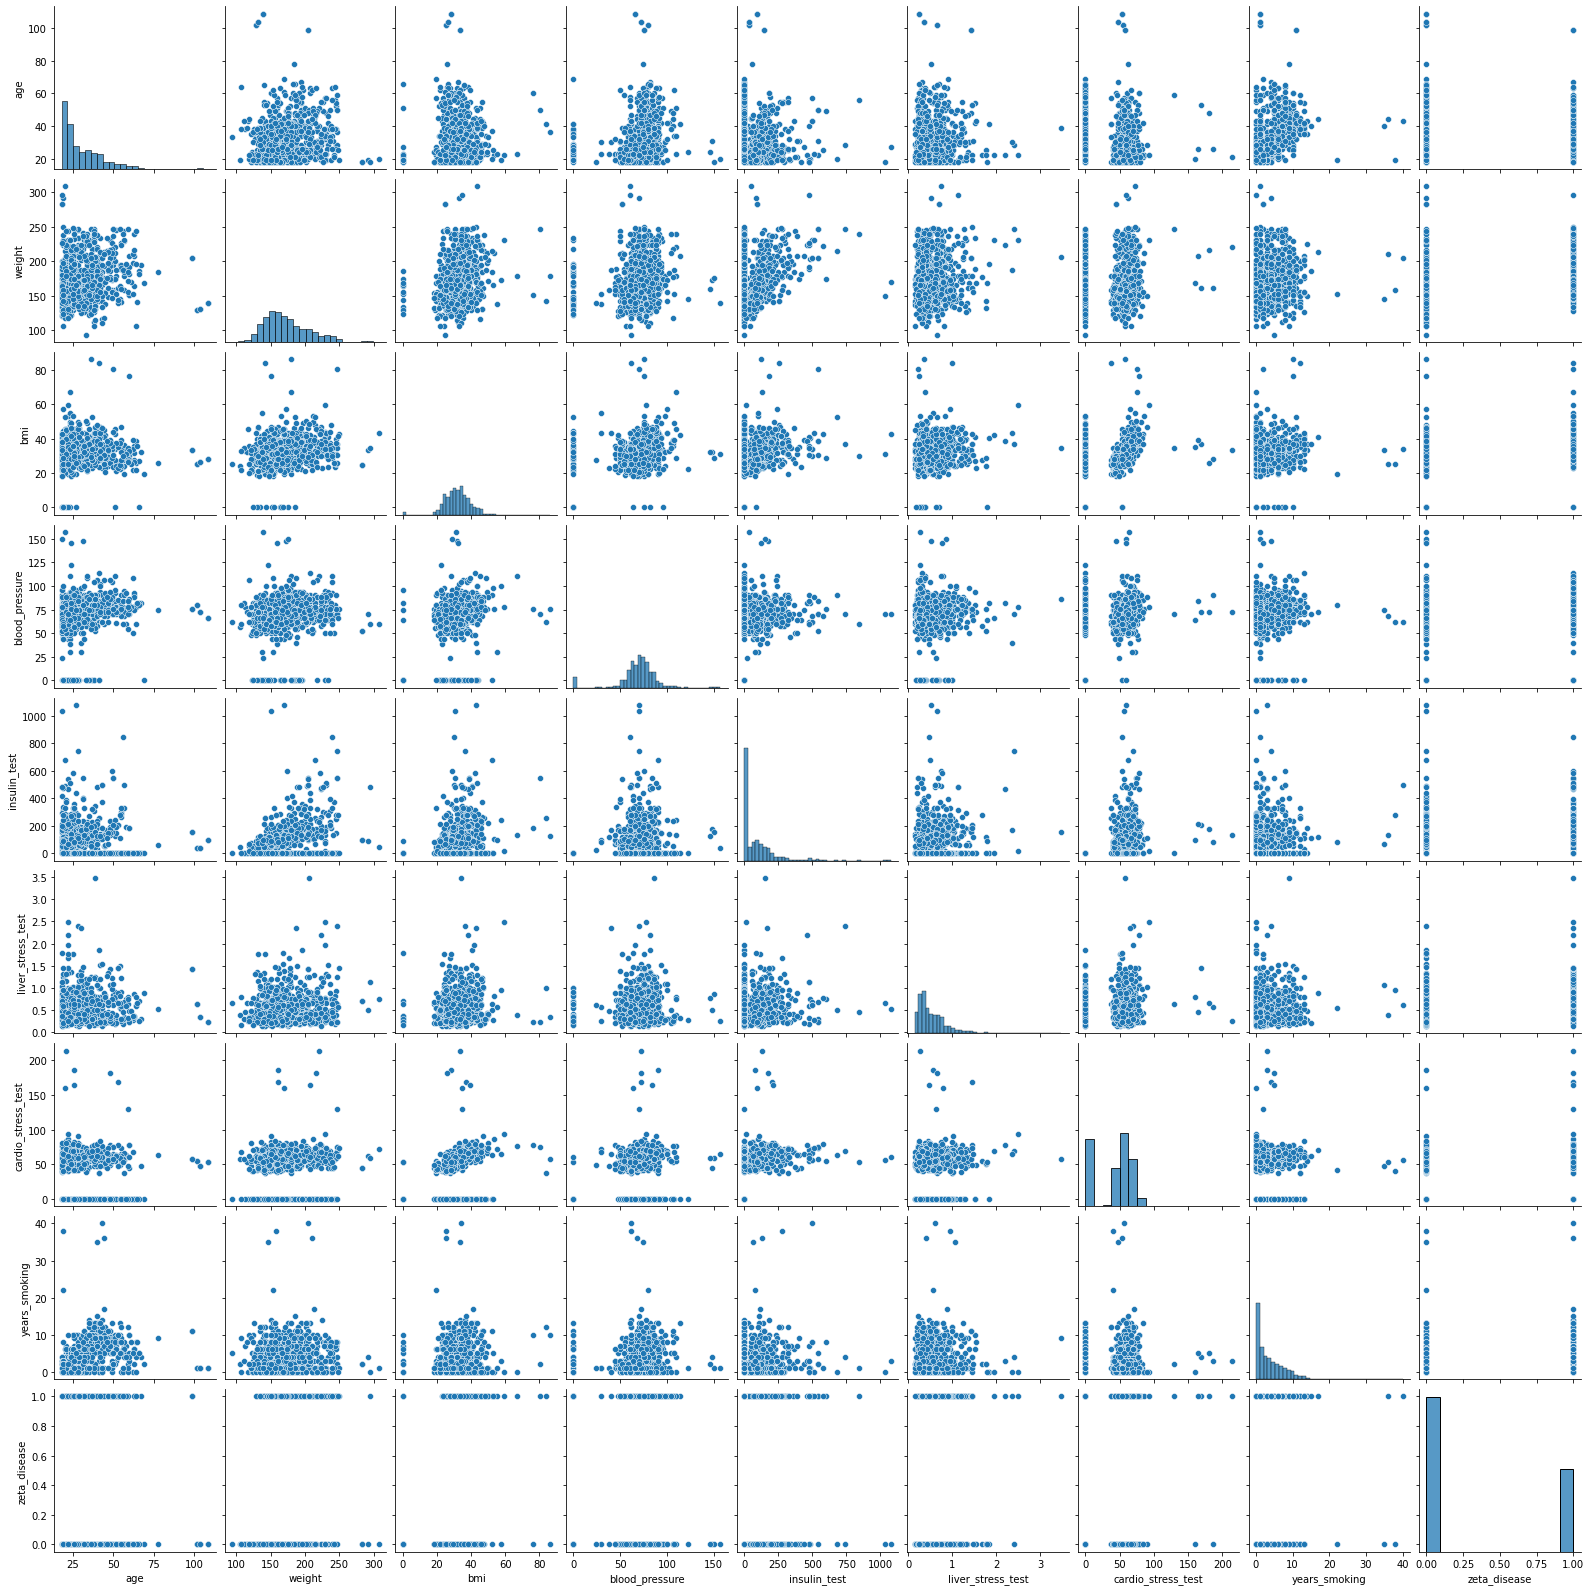

In [ ]:
sns.pairplot(training_data)

This plot is quite informative.

<br>

First, as seen in the bottom right panel, `zeta_disease` is binary. This
indicates that the popular `LassCV()` function from the library `scikit-learn` cannot be used, due to assuming the variable is continuous.

<br>

Further, upon visual inspection, we can see the distribution of each variable.
Although several are skewed, this is not a pressing issue for the task at hand.

<br>

One potential issue is the variable `insulin_test`, in so far as
it is potentially zero inflated. Typically, this might not be too concerning, but given the nature of the variable, it seems suspicious that there are many small values (perhaps a coding error). Indeed, we see that nearly half of the subjects have a zero for their score, i.e.,

In [ ]:
(training_data.insulin_test ==0).sum()

370

Of course, I am not a medical doctor so this could be just fine. In my work as a data scientist, I would **defintely** bring this up to the team lead for discussion. For the sake of this assingment, we will include `insulin_test`
in the model.

<br>

As a final check, I inspect the data frame for missing values. If so,
then this would require some thought as to how best to deal with them.
Such strategies include deleting entire rows, an EM algorithm for imputation,
mean imputation, etc.

In [ ]:
pd.DataFrame(training_data.isna().sum())

,0
age,0
weight,0
bmi,0
blood_pressure,0
insulin_test,0
liver_stress_test,0
cardio_stress_test,0
years_smoking,0
zeta_disease,0


## Test Data

I now repeat the same steps for the test data. For brevity, I look at the correlations and `pairsplot`

In [ ]:
test_data.drop(columns= "zeta_disease").corr()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
age,1.000000,0.410316,-0.295070,0.035746,0.167818,0.176846,-0.034986,0.541663
weight,0.410316,1.000000,-0.295132,-0.266621,0.550581,0.326797,0.069666,0.176502
bmi,-0.295070,-0.295132,1.000000,0.292750,0.153972,-0.124418,0.573829,-0.051418
blood_pressure,0.035746,-0.266621,0.292750,1.000000,-0.108412,-0.037782,0.035049,-0.007037
insulin_test,0.167818,0.550581,0.153972,-0.108412,1.000000,0.208459,0.509533,0.149285
liver_stress_test,0.176846,0.326797,-0.124418,-0.037782,0.208459,1.000000,0.207627,0.234922
cardio_stress_test,-0.034986,0.069666,0.573829,0.035049,0.509533,0.207627,1.000000,-0.045235
years_smoking,0.541663,0.176502,-0.051418,-0.007037,0.149285,0.234922,-0.045235,1.000000


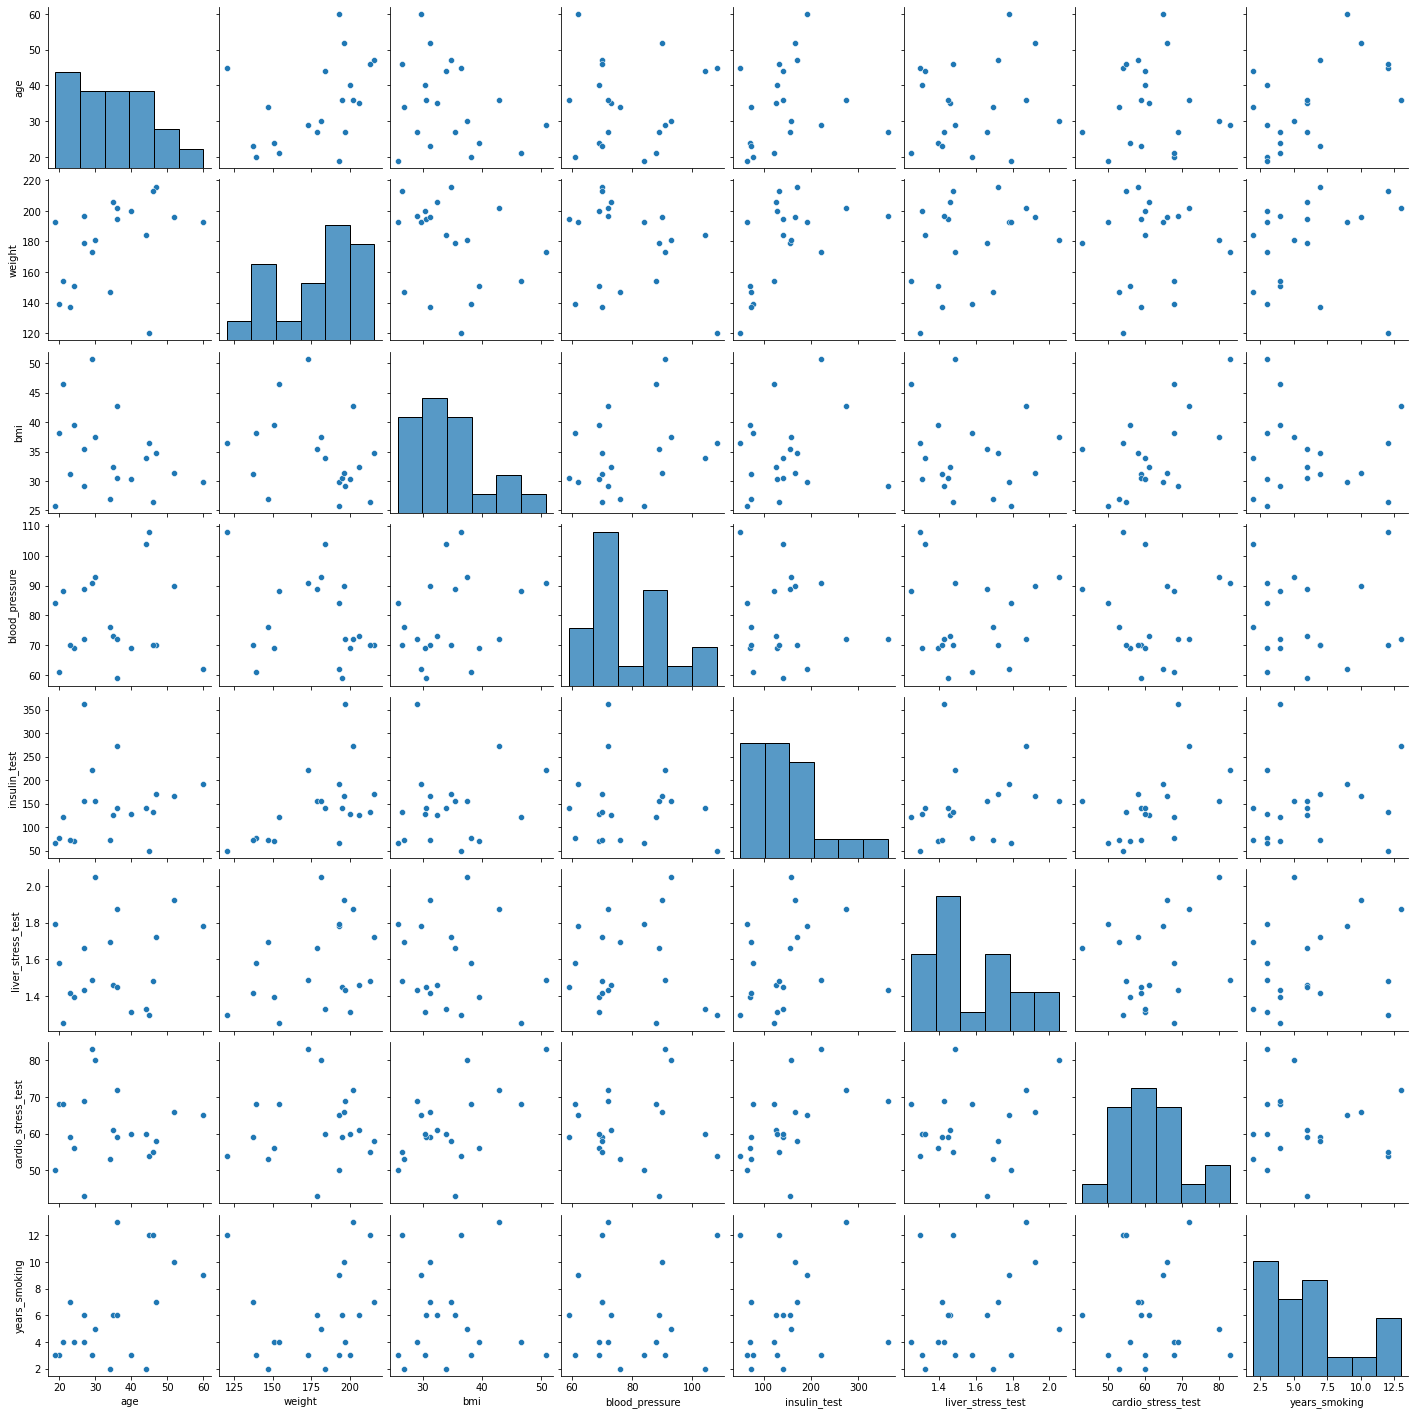

In [ ]:
sns.pairplot(test_data.drop(columns= "zeta_disease"))

In this case, we now see that `bmi` and `weight` has a negative correlation (about -0.30). While this is only 20 observations and could be just from randomness in the train/test split, I would still flag this as potentially suspicious. For example, from a quick google search, we see that `bmi`
and `weight` are (at least sometimes) highly correlated (https://archive.unu.edu/unupress/food2/UID10E/UID10E05.HTM).

<br>

I would note this to discuss with the team to get their thoughts.

## Summary

Together, this exploratory data analysis shed light upon some potential issues. Again, if I thought there might be an error in the data 
(e.g., something coded incorrectly or that did not seem to make sense), I would bring this to the team leads attention.

<br>

With that in mind, in the the next section I build the predictive models.

# Predictive Models

I chose to go with models that might be considered "simple" (or non state-of-art). This is for a couple of reasons. Due the nature of the data, in particular the $p/n$ ratio, this suggests that even non-regularized 
(non-penalized maximum likelihood) methods could provide adequate prediction performance (see my machine learning research here: https://www.tandfonline.com/doi/abs/10.1080/00273171.2019.1575716). Further, because the focus in on disease, it would seem that we might also like to make *inference* on the effects (e.g., confidence intervals, $p$-values). This is not typically possible with more elaborate machine learning approaches.

<br>

Accordingly, I employ a non-regularized logistic regression (a baseline, if you will) and also an $L_1$-penalized logistic regression. Although there are some challenges making inference on $L_1$ based estimates, more recent approaches allow for *de-sparsifying* the estimates, from which valid confidence intervals
can be computed (e.g., https://ieeexplore.ieee.org/abstract/document/6866880)

<br>

Note also that I am familiar with a variety of machine learning approaches---I am the lead developer of an `R` package that is geared towards non-convex regularizaton (https://donaldrwilliams.github.io/GGMncv/).


## Format Data

The following prepares the data for the prediction task

In [ ]:
# training data
X_train = training_data.drop(columns= "zeta_disease")
y_train = training_data[["zeta_disease"]]


# test data
X_test = test_data.drop(columns= "zeta_disease")
y_test  = test_data[["zeta_disease"]]

Next I define a function that "scales" the data which is important 
for $L_1$-regularization. 

<br>

Further, the function returns the means and standard deviations of the **training** data. This is of paramount importance, because the **test**
data should be standardized according to the **training** data. If we instead
scaled all the data first, this would be a case of data leakage and it could compromise the results (see here: https://sebastianraschka.com/faq/docs/scale-training-test.html).

In [ ]:
def scale(X):
  means = X.mean()
  stds  = X.std()
  X_scaled = (X - means) / stds
  return {"X_scaled": X_scaled, "stds": stds, "means": means}

# scale the training data
scaling_info = scale(X_train)

X_train_scaled = scaling_info["X_scaled"]

# scale test data based on training means and stds
X_test_scaled = (X_test - scaling_info["means"]) / scaling_info["stds"]

Next check to be sure the means and standard devations are 0 and 1, respectively.

In [ ]:
scale_check = pd.concat([np.round(X_train_scaled.mean(), 5), X_train_scaled.std()], 
                        axis =1, 
                        ignore_index = True)

scale_check.columns = ["mean", "std"]

scale_check

,mean,std
age,0.0,1.0
weight,0.0,1.0
bmi,-0.0,1.0
blood_pressure,0.0,1.0
insulin_test,-0.0,1.0
liver_stress_test,-0.0,1.0
cardio_stress_test,-0.0,1.0
years_smoking,0.0,1.0


## Custom Cross-Validation Function

If the data was continous, I would use `LassoCV` which has many additional 
features, over and above estimating the model (e.g., the solution path). To 
my knowledge, `LogisticRegressionCV` is more limited, has less examples, and I would like a bit more control for this task. Accordingly, I made my own which could then of course be used for future predictive tasks and by other teammates.

In [ ]:
# transpose in r
t = np.transpose

def LassoCV_logistic(X=None, y=None, 
                     alpha_min=0.0001, 
                     alpha_max = 1, 
                     alpha_n = 100, 
                     cv_folds = 5, 
                     scoring = "auc"):
  
  alpha = np.linspace(start=alpha_min, stop=alpha_max, num=alpha_n)
  
  cv_scores = np.empty([cv_folds, alpha_n])
  
  solution_path = pd.DataFrame()
  cv_scores = pd.DataFrame()
  
  coef_n = X.shape[1]
  coef_id = pd.DataFrame(np.linspace(1, coef_n, coef_n)[:,], columns = ["coef_id"])
  
  for a in range(0, alpha_n):
    
    setup = LogisticRegression(penalty='l1', C=alpha[a], solver='liblinear')
    
    fit_a = setup.fit(X, np.ravel(y))
    
    coef = t(pd.DataFrame(fit_a.coef_, index=["coef"]))
   
    alpha_a = pd.DataFrame(np.repeat(alpha[a], coef_n)[:,], columns = ["alpha_a"])
    
    alpha_a_cv = pd.DataFrame(np.repeat(alpha[a], cv_folds)[:,], columns = ["alpha_a"])

    solution_path = solution_path.append(pd.concat([coef_id, coef, alpha_a], axis =1))

    cv_scores = cv_scores.append(pd.concat([pd.DataFrame(cross_val_score(setup, X, np.ravel(y), 
                                                               cv=cv_folds, 
                                                               scoring=scoring)), alpha_a_cv], axis= 1))

  return {"solution_path": solution_path, "cv_scores": cv_scores, "alpha": alpha}

Next I fit the model with 10 fold cross-validation. This choice is motivated by there being quite a bit of data and that this is the default in the 
`R` package **glmnet** which I have found works great for predictive tasks. 

In [ ]:
fit = LassoCV_logistic(X=X_train_scaled, y=y_train, 
                       alpha_n = 100, 
                       cv_folds = 10, 
                       alpha_max = 0.3, 
                       scoring="roc_auc")

I chose to use `roc_auc`, which I have found works well in my data science work. Note that here are a variety of options (https://scikit-learn.org/stable/modules/model_evaluation.html), and typically I would choose this based on considering the importance of false postive/negatives, and what will be used on the test dataset.

## Solution Path

The following makes the solution path, which shows the weights as a function of the amount of regularization. This is seamless with `LassoCV` (e.g., https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py), which 
I mimiced with `LassoCV_logistic`.


[Text(0, 0.5, 'Coefficient Size'), Text(0.5, 0, 'Regularization Parameter')]

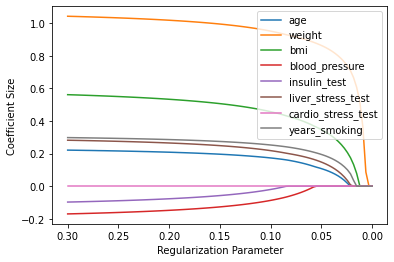

In [ ]:
solution_path = fit["solution_path"]

solution_path['coef_id'] = solution_path.coef_id.astype(str)

solution_path = solution_path.reset_index()

plt = sns.lineplot(x='alpha_a', 
                   hue = 'coef_id',
                   y='coef',
                   data=solution_path, 
                   legend= False)

plt.invert_xaxis()

plt.legend(title='', loc='upper right', labels=X_train.columns)

plt.set(ylabel='Coefficient Size', xlabel='Regularization Parameter')

Somewhat confusingly, smaller `alpha`s (regularization parameter) result in *more* regularization when using `LogisticRegression` (used inside my function).

## CV Scores

Next I look at the scores as a function of the amount of regularization. This requires some data wrangling with **pandas**

[Text(0, 0.5, 'AUC'), Text(0.5, 0, 'Regularization Parameter')]

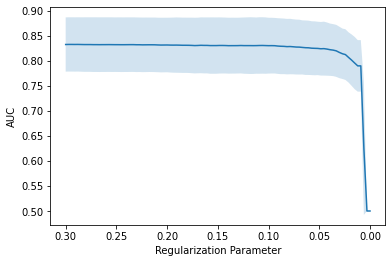

In [ ]:
scores = fit["cv_scores"]

scores_summarized = pd.concat([scores.groupby('alpha_a').mean(),scores.groupby('alpha_a').std()], axis =1)

scores_summarized.reset_index(inplace=True)

scores_summarized.columns = ["alpha", "means", "stds"]

plt = sns.lineplot(data=scores_summarized, x="alpha", y="means", ci='stds')
plt.fill_between(scores_summarized.alpha, 
                 scores_summarized.means - scores_summarized.stds, 
                 scores_summarized.means + scores_summarized.stds, alpha=0.2)

plt.invert_xaxis()

plt.set(ylabel='AUC', xlabel='Regularization Parameter')

We notice that as there is more regularization, the AUC scores goes to 0.5, or that the predictions are basically *random guesses*.

## Select Model

I select the model that has the highest AUC score.

In [ ]:
scores_summarized = scores_summarized.reset_index()

max_auc = scores_summarized.loc[scores_summarized['means'].idxmax()]["index"]

selected_alpha = fit["alpha"][int(max_auc)]

selected_alpha

0.2939414141414141

Hence, the best AUC was achieved when there was barely any regularization at all.

## Non-Regularized

I now look at the AUC of non-regularized logistic regression (albiet CV on the training data). If there is not much advantage of the $L_1$-penalty, I would consider going with the non-regularized option, assuming we might also be interested in 
making *inference* on the coefficients. If not, then this still serves as 
a nice baseline to see the added value of more complex approaches.

<br>

I first look at the estimates from **scikit-learn** and then compare to `R`. This is a sanity check, in so far as I trust `R` more for classical regression
modeling. Also that **scikit-learn** has several algorithms to choose from,
and like to be sure it matches those obtained from `R`.

In [ ]:
logreg = LogisticRegression(penalty='none', solver="newton-cg")

fit = logreg.fit(X_train_scaled, np.ravel(y_train))

# intercept
print(pd.DataFrame(fit.intercept_))

          0
0 -0.820724


In [ ]:
# weights
print(t(pd.DataFrame(fit.coef_)))

          0
0  0.248570
1  1.094962
2  0.622244
3 -0.217304
4 -0.140710
5  0.317989
6  0.000813
7  0.323586


Now compare those estimates to `glm` in `R`

In [ ]:
%load_ext rpy2.ipython

# export data to R
%R -i X_train_scaled -i y_train


In [ ]:
%%R
fit = glm(as.matrix(y_train) ~ as.matrix(X_train_scaled), family = 'binomial')

coefs = coef(fit)

# intercept
round(coefs[1], 6)

(Intercept) 
  -0.820724 


In [ ]:
%%R
# weights
round(as.matrix(as.numeric(coefs[-1])), 6)

          [,1]
[1,]  0.248570
[2,]  1.094962
[3,]  0.622244
[4,] -0.217304
[5,] -0.140710
[6,]  0.317990
[7,]  0.000813
[8,]  0.323586


Notice that the estimates are the same.

The following computes the CV AUC for the non-regularized model and compares it to the best regularized model, as selected above.

In [ ]:
scores = cross_val_score(logreg, X_train_scaled, np.ravel(y_train), cv=10,  scoring="roc_auc")

print("Regularized AUC: " + str(scores_summarized.loc[max_auc,:]["means"]),
      "\nNon-regularized AUC: " + str(np.mean(scores)))

Regularized AUC: 0.8325659839810783 
Non-regularized AUC: 0.8315369640841338


The results are **very** similar, perhaps basically the same.

<br>

For a purely predictive task, it would seem that we would certainly go with the 
regularized model, even though AUC estimates are the same to two decimal places.

<br>

Of course, this is cross-validation on the *training* dataset and ultimately, for this task, we care about prediction on the test data. In practice, I would likely have access to the test data and could check to see how well each does before making any decisions about what model should be used, say, in production
or to provide insights into the customer base.

# Predictions

With the model in hand, I now compute the predictions from the test data.

Note also that I save the files in the Kaggle format.

In [ ]:
# notice `selected_alpha`
l1_logreg = LogisticRegression(penalty='l1', C=selected_alpha, solver='liblinear')

fit = l1_logreg.fit(X_train_scaled, np.ravel(y_train))

# kaggle
Predicted = pd.DataFrame(fit.predict(X_test_scaled), columns=["Predicted"])

Id = pd.DataFrame(np.linspace(1,20,20), columns=["Id"])

# requires string
Id['Id'] = Id.Id.astype(str)

submission = pd.concat([Id, Predicted], axis=1)

# save submission
submission.to_csv('notebook/submission.csv')

## Selected Features

The estimates of exactly zero are often considered unimportant for prediction. In this case, all but `stress_test` were selected.

In [ ]:
t(pd.DataFrame(fit.coef_))

,0
0,0.220374
1,1.040626
2,0.559657
3,-0.169238
4,-0.096705
5,0.280918
6,0.000000
7,0.297171


## Non-Regularized Based Predictions

0ut of curiosity I compared the predictions to the non-regularized model. The following shows that the predictions are the same.

In [ ]:
np.all( logreg.fit(X_train_scaled, np.ravel(y_train)).predict(X_test_scaled) == submission.Predicted)

True

Because the goal here was prediction, I would indeed go with the best model, as indicated by the CV score.

But I think it is important to note that we can often get acceptable prediction
with simpler approaches, which could come in handy when the goal is not
only prediction (as but one example). Further, several machine learning approaches are computationally intensive, in which case a simpler approach might be preferred, depending on the size of the problem.

# Summary

In this task, I predicted the presence of zeta disease. Based on cross-validation (with the training data), a final model was selected to
compare the predictions to the expected values in the test data.

Further, for the goal of prediction, the stress test did not seem important, whereas the remaining 7 feature were selected in the model.